In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitor_sma1', 'station_visitors_mean', 'all_count_y1', 'all_count_y5'])
len(lag_cols)

14

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [20]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [23]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=True,use_dropout=False,
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [25]:
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('lstm_valid{}_preds.pkl'.format(j),'wb'))



1
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 5803 records out of 5803 records
no valid set
2491
0
14 1 (1, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 47s 19ms/step - loss: 0.3532 - total_loss: 0.3532 - reg_loss: 0.3532 - val_loss: 0.3206 - val_total_loss: 0.3206 - val_reg_loss: 0.3206
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3141 - total_loss: 0.3141 - reg_loss: 0.3141 - val_loss: 0.2867 - val_total_loss: 0.2867 - val_reg_loss: 0.2867
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3038 - total_loss: 0.3038 - reg_loss: 0.3038 - val_loss: 0.2765 - val_total_loss: 0.2765 - val_reg_loss: 0.2765
E

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901997  0.027113  0.256297    7  2017-04-16
472     2.507290  2.603070 -0.095779  0.263796    1  2017-04-17
473     2.661330  2.666839 -0.005510  0.274694    2  2017-04-18
474     2.754815  2.869291 -0.114477  0.256645    3  2017-04-19
475     2.713762  2.790960 -0.077198  0.272120    4  2017-04-20
476     2.999000  2.992977  0.006023  0.169153    5  2017-04-21
477     3.075529  3.127055 -0.051525  0.213135    6  2017-04-22

best_epochs [11, 14, 15, 12, 16]
(829, 1) 2.63977153869 

2
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 6632 records out of 6632 records
no valid set
2491
0
14 1 (2, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 19ms/step - loss: 0.3694 - total_loss: 0.3694 - reg_loss: 0.3694 - val_loss: 0.3331 - val_total_loss: 0.3331 - val_reg_loss: 0.3331
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181 - val_loss: 0.2988 - val_total_loss: 0.2988 - val_reg_loss: 0.2988
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.848643  0.080467  0.267019    6  2017-04-15
471     2.507290  2.533657 -0.026366  0.252886    7  2017-04-16
472     2.661330  2.674124 -0.012794  0.279738    1  2017-04-17
473     2.754815  2.815836 -0.061021  0.244480    2  2017-04-18
474     2.713762  2.818939 -0.105177  0.290422    3  2017-04-19
475     2.999000  2.983312  0.015688  0.175480    4  2017-04-20
476     3.075529  3.069900  0.005629  0.213079    5  2017-04-21

best_epochs [15, 18, 20, 13, 16]
(829, 1) 2.56477718956 

3
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 7461 records out of 7461 records
no valid set
2491
0
14 1 (3, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5789 - total_loss: 3.5789 - reg_loss: 3.5789Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5766 - total_loss: 3.5766 - reg_loss: 3.5766 - val_loss: 0.8723 - val_total_loss: 0.8723 - val_reg_loss: 0.8723
best_epochs [1]
individual loss [ 0.87225207]
[ 1.] 0.872252069377
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517,

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764 - val_loss: 0.2643 - val_total_loss: 0.2643 - val_reg_loss: 0.2643
Epoch 16/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2745 - total_loss: 0.2745 - reg_loss: 0.2745 - val_loss: 0.2682 - val_total_loss: 0.2682 - val_reg_loss: 0.2682
Epoch 17/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732 - val_loss: 0.2656 - val_total_loss: 0.2656 - val_reg_loss: 0.2656
Epoch 18/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718 - val_loss: 0.2651 - val_total_loss: 0.2651 - val_reg_loss: 0.2651
Epoch 19/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701 - val_loss: 0.2545 - val_total_loss: 0.2545 - val_reg_loss: 0.2545
Epoch 20/100
2491/2491 [===================

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.942125 -0.013015  0.258607    5  2017-04-14
470     2.507290  2.562478 -0.055187  0.257722    6  2017-04-15
471     2.661330  2.666864 -0.005534  0.273724    7  2017-04-16
472     2.754815  2.832082 -0.077267  0.252564    1  2017-04-17
473     2.713762  2.811273 -0.097511  0.281091    2  2017-04-18
474     2.999000  2.998841  0.000158  0.180229    3  2017-04-19
475     3.075529  3.077238 -0.001708  0.213167    4  2017-04-20

best_epochs [19, 23, 20, 24, 14]
(829, 1) 2.57840901864 

4
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 8290 records out of 8290 records
no valid set
2491
0
14 1 (4, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3500 - total_loss: 0.3500 - reg_loss: 0.3500 - val_loss: 0.3027 - val_total_loss: 0.3027 - val_reg_loss: 0.3027
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128 - val_loss: 0.2859 - val_total_loss: 0.2859 - val_reg_loss: 0.2859
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3055 - total_loss: 0.3055 - reg_loss: 0.3055 - val_loss: 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.907185  0.021924  0.253613    4  2017-04-13
469     2.507290  2.573526 -0.066236  0.255536    5  2017-04-14
470     2.661330  2.597713  0.063617  0.286551    6  2017-04-15
471     2.754815  2.775595 -0.020780  0.244026    7  2017-04-16
472     2.713762  2.835175 -0.121414  0.283977    1  2017-04-17
473     2.999000  3.013918 -0.014919  0.180020    2  2017-04-18
474     3.075529  3.109272 -0.033742  0.214150    3  2017-04-19

best_epochs [13, 17, 14, 15, 16]
(829, 1) 2.6939362657 

5
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 9119 records out of 9119 records
no valid set
2491
0
14 1 (5, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3480 - total_loss: 0.3480 - reg_loss: 0.3480 - val_loss: 0.2938 - val_total_loss: 0.2938 - val_reg_loss: 0.2938
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052 - val_loss: 0

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.922194  0.006916  0.261654    3  2017-04-12
468     2.507290  2.598658 -0.091367  0.267766    4  2017-04-13
469     2.661330  2.628891  0.032439  0.275430    5  2017-04-14
470     2.754815  2.737910  0.016905  0.235415    6  2017-04-15
471     2.713762  2.769157 -0.055395  0.270805    7  2017-04-16
472     2.999000  3.025220 -0.026221  0.177348    1  2017-04-17
473     3.075529  3.103745 -0.028215  0.216902    2  2017-04-18

best_epochs [12, 17, 11, 15, 16]
(829, 1) 2.75656499632 

6
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 9948 records out of 9948 records
no valid set
2491
0
14 1 (6, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3467 - total_loss: 0.3467 - reg_loss: 0.3467 - val_loss: 0.2941 - val_total_loss: 0.2941 - val_reg_loss: 0.2941
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122 - val_loss: 0.2941 - val_total_loss: 0.2941 - val_reg_loss: 0.2941
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3063 - total_loss: 0.3063 - reg_loss: 0.3063 - val_loss: 

Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656 - val_loss: 0.2626 - val_total_loss: 0.2626 - val_reg_loss: 0.2626
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 0.2632 - val_loss: 0.2690 - val_total_loss: 0.2690 - val_reg_loss: 0.2690
Epoch 25/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610 - val_loss: 0.2656 - val_total_loss: 0.2656 - val_reg_loss: 0.2656
best_epochs [20, 18, 23, 21, 16]
individual loss [ 0.26353887  0.26389035  0.2663426   0.26564158  0.26446996]
[ 0.28163559  0.15031594  0.19002605  0.15302014  0.22500228] 0.257765090503
best_epochs [20, 18, 23, 21, 16]
0.257765090487 0.257765090487
(1, 0.25776509048657648)
0.257765090487
best_epochs [20, 18, 23, 21, 16]
(9948, 1) 2.7138407364 (9948, 2)


y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.884515  0.044595  0.251834    2  2017-04-11
467     2.507290  2.587881 -0.080591  0.258018    3  2017-04-12
468     2.661330  2.623673  0.037656  0.270938    4  2017-04-13
469     2.754815  2.724379  0.030436  0.229294    5  2017-04-14
470     2.713762  2.758527 -0.044765  0.263502    6  2017-04-15
471     2.999000  3.028954 -0.029955  0.179190    7  2017-04-16
472     3.075529  3.071239  0.004290  0.211954    1  2017-04-17

best_epochs [20, 18, 23, 21, 16]
(829, 1) 2.99678047729 

7
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 10777 records out of 10777 records
no valid set
2491
0
14 1 (7, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5783 - total_loss: 3.5783 - reg_loss: 3.5783Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 45s 18ms/step - loss: 3.5749 - total_loss: 3.5749 - reg_loss: 3.5749 - val_loss: 0.8683 - val_total_loss: 0.8683 - val_reg_loss: 0.8683
best_epochs [1]
individual loss [ 0.86849719]
[ 1.] 0.868497194797
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2805 - total_loss: 0.2805 - reg_loss: 0.2805 - val_loss: 0.2667 - val_total_loss: 0.2667 - val_reg_loss: 0.2667
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2781 - total_loss: 0.2781 - reg_loss: 0.2781 - val_loss: 0.2625 - val_total_loss: 0.2625 - val_reg_loss: 0.2625
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2768 - total_loss: 0.2768 - reg_loss: 0.2768 - val_loss: 0.2699 - val_total_loss: 0.2699 - val_reg_loss: 0.2699
Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2753 - total_loss: 0.2753 - reg_loss: 0.2753 - val_loss: 0.2662 - val_total_loss: 0.2662 - val_reg_loss: 0.2662
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735 - val_loss: 0.2660 - val_total_loss: 0.2660 - val_reg_loss: 0.2660
Epoch 25/100
2491/2491 [===================

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.849844  0.079266  0.256849    1  2017-04-10
466     2.507290  2.592476 -0.085185  0.268771    2  2017-04-11
467     2.661330  2.600091  0.061239  0.279139    3  2017-04-12
468     2.754815  2.738309  0.016506  0.233755    4  2017-04-13
469     2.713762  2.750068 -0.036306  0.253247    5  2017-04-14
470     2.999000  3.001562 -0.002563  0.173202    6  2017-04-15
471     3.075529  3.078943 -0.003413  0.211343    7  2017-04-16

best_epochs [21, 18, 24, 23, 20]
(829, 1) 3.03469632121 

8
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 11606 records out of 11606 records
no valid set
2491
0
14 1 (8, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3786 - total_loss: 0.3786 - reg_loss: 0.3786 - val_loss: 0.3127 - val_total_loss: 0.3127 - val_reg_loss: 0.3127
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3314 - total_loss: 0.3314 - reg_loss: 0.3314 - val_loss: 0.3077 - val_total_loss: 0.3077 - val_reg_loss: 0.3077
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238 - val_loss

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.886727  0.042383  0.262721    7  2017-04-09
465     2.507290  2.572080 -0.064790  0.254240    1  2017-04-10
466     2.661330  2.625924  0.035406  0.282637    2  2017-04-11
467     2.754815  2.717516  0.037299  0.239105    3  2017-04-12
468     2.713762  2.731860 -0.018098  0.250558    4  2017-04-13
469     2.999000  2.978489  0.020511  0.168464    5  2017-04-14
470     3.075529  3.121629 -0.046100  0.208065    6  2017-04-15

best_epochs [14, 18, 17, 9, 19]
(829, 1) 2.65230977093 

9
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 12435 records out of 12435 records
no valid set
2491
0
14 1 (9, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5817 - total_loss: 3.5817 - reg_loss: 3.5817Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5782 - total_loss: 3.5782 - reg_loss: 3.5782 - val_loss: 0.8691 - val_total_loss: 0.8691 - val_reg_loss: 0.8691
best_epochs [1]
individual loss [ 0.86939187]
[ 1.] 0.869391866875
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765 - val_loss: 0.2751 - val_total_loss: 0.2751 - val_reg_loss: 0.2751
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742 - val_loss: 0.2755 - val_total_loss: 0.2755 - val_reg_loss: 0.2755
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2715 - total_loss: 0.2715 - reg_loss: 0.2715 - val_loss: 0.2664 - val_total_loss: 0.2664 - val_reg_loss: 0.2664
Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694 - val_loss: 0.2767 - val_total_loss: 0.2767 - val_reg_loss: 0.2767
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666 - val_loss: 0.2773 - val_total_loss: 0.2773 - val_reg_loss: 0.2773
Epoch 25/100
2491/2491 [===================

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.862381  0.066729  0.260114    6  2017-04-08
464     2.507290  2.554803 -0.047513  0.245018    7  2017-04-09
465     2.661330  2.625968  0.035362  0.274150    1  2017-04-10
466     2.754815  2.733121  0.021694  0.226770    2  2017-04-11
467     2.713762  2.748899 -0.035137  0.243993    3  2017-04-12
468     2.999000  2.960581  0.038418  0.170409    4  2017-04-13
469     3.075529  3.093892 -0.018363  0.192979    5  2017-04-14

best_epochs [22, 18, 19, 14, 26]
(829, 1) 2.49022204352 

10
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 13264 records out of 13264 records
no valid set
2491
0
14 1 (10, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5813 - total_loss: 3.5813 - reg_loss: 3.5813Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5791 - total_loss: 3.5791 - reg_loss: 3.5791 - val_loss: 0.8686 - val_total_loss: 0.8686 - val_reg_loss: 0.8686
best_epochs [1]
individual loss [ 0.86903948]
[ 1.] 0.869039480009
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

Epoch 5/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3059 - total_loss: 0.3059 - reg_loss: 0.3059 - val_loss: 0.2922 - val_total_loss: 0.2922 - val_reg_loss: 0.2922
Epoch 6/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3040 - total_loss: 0.3040 - reg_loss: 0.3040 - val_loss: 0.2812 - val_total_loss: 0.2812 - val_reg_loss: 0.2812
Epoch 7/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3013 - total_loss: 0.3013 - reg_loss: 0.3013 - val_loss: 0.2825 - val_total_loss: 0.2825 - val_reg_loss: 0.2825
Epoch 8/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3006 - total_loss: 0.3006 - reg_loss: 0.3006 - val_loss: 0.2776 - val_total_loss: 0.2776 - val_reg_loss: 0.2776
Epoch 9/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2978 - total_loss: 0.2978 - reg_loss: 0.2978 - val_loss: 0.2835 - val_total_loss: 0.2835 - val_reg_loss: 0.2835
Epoch 10/100
2491/2491 [===========

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.880190  0.048920  0.264095    5  2017-04-07
463     2.507290  2.608034 -0.100743  0.265939    6  2017-04-08
464     2.661330  2.655946  0.005384  0.280810    7  2017-04-09
465     2.754815  2.731603  0.023211  0.245442    1  2017-04-10
466     2.713762  2.743372 -0.029610  0.261243    2  2017-04-11
467     2.999000  2.966919  0.032080  0.176858    3  2017-04-12
468     3.075529  3.098704 -0.023175  0.201535    4  2017-04-13

best_epochs [14, 16, 11, 18, 12]
(829, 1) 2.64305046994 

11
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 14093 records out of 14093 records
no valid set
2491
0
14 1 (11, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5810 - total_loss: 3.5810 - reg_loss: 3.5810Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5775 - total_loss: 3.5775 - reg_loss: 3.5775 - val_loss: 0.8686 - val_total_loss: 0.8686 - val_reg_loss: 0.8686
best_epochs [1]
individual loss [ 0.86870405]
[ 1.] 0.868704045163
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

Epoch 18/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.2796 - total_loss: 0.2796 - reg_loss: 0.2796 - val_loss: 0.2819 - val_total_loss: 0.2819 - val_reg_loss: 0.2819
Epoch 19/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2787 - total_loss: 0.2787 - reg_loss: 0.2787 - val_loss: 0.2831 - val_total_loss: 0.2831 - val_reg_loss: 0.2831
Epoch 20/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765 - val_loss: 0.2690 - val_total_loss: 0.2690 - val_reg_loss: 0.2690
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2743 - total_loss: 0.2743 - reg_loss: 0.2743 - val_loss: 0.2731 - val_total_loss: 0.2731 - val_reg_loss: 0.2731
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723 - val_loss: 0.2709 - val_total_loss: 0.2709 - val_reg_loss: 0.2709
Epoch 23/100
2491/2491 [======

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.938368 -0.009258  0.259980    4  2017-04-06
462     2.507290  2.586755 -0.079465  0.251711    5  2017-04-07
463     2.661330  2.662716 -0.001386  0.276906    6  2017-04-08
464     2.754815  2.730282  0.024533  0.231513    7  2017-04-09
465     2.713762  2.752588 -0.038827  0.255483    1  2017-04-10
466     2.999000  2.975357  0.023643  0.168003    2  2017-04-11
467     3.075529  3.093061 -0.017531  0.199745    3  2017-04-12

best_epochs [20, 22, 15, 11, 17]
(829, 1) 2.72296462205 

12
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 14922 records out of 14922 records
no valid set
2491
0
14 1 (12, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.5536 - total_loss: 0.5536 - reg_loss: 0.5536 - val_loss: 0.3009 - val_total_loss: 0.3009 - val_reg_loss: 0.3009
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3234 - total_loss: 0.3234 - reg_loss: 0.3234 - val_loss: 0.2915 - val_total_loss: 0.2915 - val_reg_loss: 0.2915
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.921262  0.007848  0.263509    3  2017-04-05
461     2.507290  2.664923 -0.157632  0.284504    4  2017-04-06
462     2.661330  2.691047 -0.029718  0.285979    5  2017-04-07
463     2.754815  2.744079  0.010736  0.245654    6  2017-04-08
464     2.713762  2.769349 -0.055587  0.264909    7  2017-04-09
465     2.999000  2.985163  0.013837  0.176855    1  2017-04-10
466     3.075529  3.092411 -0.016882  0.207579    2  2017-04-11

best_epochs [13, 16, 8, 10, 11]
(829, 1) 2.77934370223 

13
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 15751 records out of 15751 records
no valid set
2491
0
14 1 (13, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5795 - total_loss: 3.5795 - reg_loss: 3.5795Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5760 - total_loss: 3.5760 - reg_loss: 3.5760 - val_loss: 0.8668 - val_total_loss: 0.8668 - val_reg_loss: 0.8668
best_epochs [1]
individual loss [ 0.86744523]
[ 1.] 0.867445227931
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 18/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2835 - total_loss: 0.2835 - reg_loss: 0.2835 - val_loss: 0.2956 - val_total_loss: 0.2956 - val_reg_loss: 0.2956
best_epochs [13, 17, 15, 14, 16]
individual loss [ 0.27900327  0.27749905  0.27791433  0.27821148  0.27718334]
[ 0.21589975  0.25718328  0.27036165  0.12041518  0.13614015] 0.271865216782
best_epochs [13, 17, 15, 14, 16]
0.271865216783 0.271865216783
(1, 0.27186521678333592)
0.271865216783
best_epochs [13, 17, 15, 14, 16]
(15751, 1) 2.74154062441 (15751, 2)


y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.908655  0.020455  0.263306    2  2017-04-04
460     2.507290  2.597284 -0.089994  0.267720    3  2017-04-05
461     2.661330  2.623129  0.038201  0.286205    4  2017-04-06
462     2.754815  2.703617  0.051198  0.242128    5  2017-04-07
463     2.713762  2.736405 -0.022643  0.263443    6  2017-04-08
464     2.999000  2.977369  0.021631  0.182386    7  2017-04-09
465     3.075529  3.094640 -0.019111  0.206461    1  2017-04-10

best_epochs [13, 17, 15, 14, 16]
(829, 1) 2.96901558148 

14
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 16580 records out of 16580 records
no valid set
2491
0
14 1 (14, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5848 - total_loss: 3.5848 - reg_loss: 3.5848Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5814 - total_loss: 3.5814 - reg_loss: 3.5814 - val_loss: 0.8687 - val_total_loss: 0.8687 - val_reg_loss: 0.8687
best_epochs [1]
individual loss [ 0.86813203]
[ 1.] 0.868132034943
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

2491/2491 [==============================] - 46s 18ms/step - loss: 0.2917 - total_loss: 0.2917 - reg_loss: 0.2917 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 16/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.2891 - total_loss: 0.2891 - reg_loss: 0.2891 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 17/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2874 - total_loss: 0.2874 - reg_loss: 0.2874 - val_loss: 0.2871 - val_total_loss: 0.2871 - val_reg_loss: 0.2871
best_epochs [12, 10, 16, 15, 17]
individual loss [ 0.28026598  0.28252351  0.28635388  0.28572441  0.28245726]
[ 0.22256847  0.35007336  0.04095544  0.02932606  0.35707668] 0.276083218193
best_epochs [12, 10, 16, 15, 17]
0.276083218232 0.276083218232
(1, 0.27608321823206372)
0.276083218232
best_epochs [12, 10, 16, 15, 17]
(16580, 1) 2.72482597598 (16580, 2)


y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.883779  0.045331  0.275839    1  2017-04-03
459     2.507290  2.603774 -0.096483  0.274474    2  2017-04-04
460     2.661330  2.616094  0.045235  0.296315    3  2017-04-05
461     2.754815  2.674491  0.080324  0.253613    4  2017-04-06
462     2.713762  2.723824 -0.010062  0.266321    5  2017-04-07
463     2.999000  2.917100  0.081900  0.186339    6  2017-04-08
464     3.075529  3.030288  0.045241  0.213121    7  2017-04-09

best_epochs [12, 10, 16, 15, 17]
(829, 1) 2.953206613 

15
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 17409 records out of 17409 records
no valid set
2491
0
14 1 (15, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5816 - total_loss: 3.5816 - reg_loss: 3.5816Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5794 - total_loss: 3.5794 - reg_loss: 3.5794 - val_loss: 0.8710 - val_total_loss: 0.8710 - val_reg_loss: 0.8710
best_epochs [1]
individual loss [ 0.87047987]
[ 1.] 0.870479867278
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2897 - total_loss: 0.2897 - reg_loss: 0.2897 - val_loss: 0.2823 - val_total_loss: 0.2823 - val_reg_loss: 0.2823
Epoch 16/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2876 - total_loss: 0.2876 - reg_loss: 0.2876 - val_loss: 0.2821 - val_total_loss: 0.2821 - val_reg_loss: 0.2821
best_epochs [11, 16, 15, 13, 7]
individual loss [ 0.28297448  0.28195066  0.28336217  0.28418087  0.28803327]
[ 0.20091181  0.4482005   0.03777478  0.10436235  0.20875055] 0.276086328437
best_epochs [11, 16, 15, 13, 7]
0.276086328382 0.276086328382
(1, 0.27608632838173619)
0.276086328382
best_epochs [11, 16, 15, 13, 7]
(17409, 1) 2.74330851421 (17409, 2)


y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.932164 -0.003054  0.284784    7  2017-04-02
458     2.507290  2.614671 -0.107380  0.274674    1  2017-04-03
459     2.661330  2.647509  0.013821  0.296599    2  2017-04-04
460     2.754815  2.679699  0.075116  0.246071    3  2017-04-05
461     2.713762  2.723743 -0.009982  0.265329    4  2017-04-06
462     2.999000  2.933161  0.065839  0.176497    5  2017-04-07
463     3.075529  3.093010 -0.017481  0.200666    6  2017-04-08

best_epochs [11, 16, 15, 13, 7]
(829, 1) 2.73960744777 

16
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 18238 records out of 18238 records
no valid set
2491
0
14 1 (16, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5841 - total_loss: 3.5841 - reg_loss: 3.5841Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5807 - total_loss: 3.5807 - reg_loss: 3.5807 - val_loss: 0.8697 - val_total_loss: 0.8697 - val_reg_loss: 0.8697
best_epochs [1]
individual loss [ 0.87006624]
[ 1.] 0.870066236252
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2839 - total_loss: 0.2839 - reg_loss: 0.2839 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2812 - total_loss: 0.2812 - reg_loss: 0.2812 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2790 - total_loss: 0.2790 - reg_loss: 0.2790 - val_loss: 0.2880 - val_total_loss: 0.2880 - val_reg_loss: 0.2880
Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2765 - total_loss: 0.2765 - reg_loss: 0.2765 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
best_epochs [18, 13, 19, 17, 16]
individual loss [ 0.28217871  0.28357171  0.28249156  0.2804365   0.28331053]
[ 0.17267309  0.2239672   0.17697619  0.31537672  0.1110068 ] 0.277138365115
best_epochs [18, 13, 19, 17, 16]
0.277138365153 0

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.912290  0.016820  0.273548    6  2017-04-01
457     2.507290  2.580347 -0.073056  0.259683    7  2017-04-02
458     2.661330  2.653022  0.008307  0.289984    1  2017-04-03
459     2.754815  2.730717  0.024097  0.242069    2  2017-04-04
460     2.713762  2.758968 -0.045207  0.265689    3  2017-04-05
461     2.999000  2.981812  0.017188  0.178057    4  2017-04-06
462     3.075529  3.071060  0.004470  0.199648    5  2017-04-07

best_epochs [18, 13, 19, 17, 16]
(829, 1) 2.54965195028 

17
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 19067 records out of 19067 records
no valid set
2491
0
14 1 (17, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2490/2491 [============================>.] - ETA: 0s - loss: 3.5756 - total_loss: 3.5756 - reg_loss: 3.5756Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 45s 18ms/step - loss: 3.5745 - total_loss: 3.5745 - reg_loss: 3.5745 - val_loss: 0.8663 - val_total_loss: 0.8663 - val_reg_loss: 0.8663
best_epochs [1]
individual loss [ 0.86618182]
[ 1.] 0.866181819847
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

Epoch 10/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3053 - total_loss: 0.3053 - reg_loss: 0.3053 - val_loss: 0.2880 - val_total_loss: 0.2880 - val_reg_loss: 0.2880
Epoch 11/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3032 - total_loss: 0.3032 - reg_loss: 0.3032 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 12/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024 - val_loss: 0.2914 - val_total_loss: 0.2914 - val_reg_loss: 0.2914
Epoch 13/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2991 - total_loss: 0.2991 - reg_loss: 0.2991 - val_loss: 0.2946 - val_total_loss: 0.2946 - val_reg_loss: 0.2946
Epoch 14/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2985 - total_loss: 0.2985 - reg_loss: 0.2985 - val_loss: 0.2877 - val_total_loss: 0.2877 - val_reg_loss: 0.2877
best_epochs [9, 11, 14, 10, 12

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.904876  0.024234  0.279078    5  2017-03-31
456     2.507290  2.593743 -0.086453  0.273929    6  2017-04-01
457     2.661330  2.661807 -0.000478  0.296771    7  2017-04-02
458     2.754815  2.762769 -0.007954  0.253319    1  2017-04-03
459     2.713762  2.786620 -0.072858  0.277510    2  2017-04-04
460     2.999000  2.998063  0.000937  0.187076    3  2017-04-05
461     3.075529  3.056768  0.018762  0.205935    4  2017-04-06

best_epochs [9, 11, 14, 10, 12]
(829, 1) 2.63756779234 

18
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 19896 records out of 19896 records
no valid set
2491
0
14 1 (18, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5779 - total_loss: 3.5779 - reg_loss: 3.5779Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 45s 18ms/step - loss: 3.5756 - total_loss: 3.5756 - reg_loss: 3.5756 - val_loss: 0.8661 - val_total_loss: 0.8661 - val_reg_loss: 0.8661
best_epochs [1]
individual loss [ 0.86687778]
[ 1.] 0.866877778598
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2823 - total_loss: 0.2823 - reg_loss: 0.2823 - val_loss: 0.2878 - val_total_loss: 0.2878 - val_reg_loss: 0.2878
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800 - val_loss: 0.2813 - val_total_loss: 0.2813 - val_reg_loss: 0.2813
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776 - val_loss: 0.2844 - val_total_loss: 0.2844 - val_reg_loss: 0.2844
Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2757 - total_loss: 0.2757 - reg_loss: 0.2757 - val_loss: 0.2884 - val_total_loss: 0.2884 - val_reg_loss: 0.2884
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730 - val_loss: 0.2918 - val_total_loss: 0.2918 - val_reg_loss: 0.2918
best_epochs [19, 16, 21, 22, 12]
individual

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.908375  0.020735  0.269806    4  2017-03-30
455     2.507290  2.547599 -0.040309  0.255575    5  2017-03-31
456     2.661330  2.642599  0.018731  0.287230    6  2017-04-01
457     2.754815  2.749262  0.005553  0.234590    7  2017-04-02
458     2.713762  2.773374 -0.059613  0.264863    1  2017-04-03
459     2.999000  3.023687 -0.024687  0.179795    2  2017-04-04
460     3.075529  3.049674  0.025856  0.199850    3  2017-04-05

best_epochs [19, 16, 21, 22, 12]
(829, 1) 2.71579052338 

19
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 20725 records out of 20725 records
no valid set
2491
0
14 1 (19, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3681 - total_loss: 0.3681 - reg_loss: 0.3681 - val_loss: 0.3202 - val_total_loss: 0.3202 - val_reg_loss: 0.3202
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3333 - total_loss: 0.3333 - reg_loss: 0.3333 - val_loss: 0.3047 - val_total_loss: 0.3047 - val_reg_loss: 0.3047
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.936035 -0.006925  0.269539    3  2017-03-29
454     2.507290  2.601991 -0.094700  0.270810    4  2017-03-30
455     2.661330  2.642134  0.019196  0.289431    5  2017-03-31
456     2.754815  2.753981  0.000834  0.241852    6  2017-04-01
457     2.713762  2.795014 -0.081253  0.275781    7  2017-04-02
458     2.999000  3.004386 -0.005386  0.185484    1  2017-04-03
459     3.075529  3.053500  0.022029  0.204174    2  2017-04-04

best_epochs [15, 18, 16, 19, 11]
(829, 1) 2.78548805778 

20
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 21554 records out of 21554 records
no valid set
2491
0
14 1 (20, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3788 - total_loss: 0.3788 - reg_loss: 0.3788 - val_loss: 0.3126 - val_total_loss: 0.3126 - val_reg_loss: 0.3126
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3366 - total_loss: 0.3366 - reg_loss: 0.3366 - val_loss: 0.3057 - val_total_loss: 0.3057 - val_reg_loss: 0.3057
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.971188 -0.042078  0.280346    2  2017-03-28
453     2.507290  2.595356 -0.088065  0.282174    3  2017-03-29
454     2.661330  2.624153  0.037177  0.296187    4  2017-03-30
455     2.754815  2.728122  0.026693  0.251835    5  2017-03-31
456     2.713762  2.764075 -0.050314  0.280033    6  2017-04-01
457     2.999000  2.972337  0.026663  0.189492    7  2017-04-02
458     3.075529  3.066547  0.008982  0.209104    1  2017-04-03

best_epochs [14, 16, 11, 17, 15]
(829, 1) 2.90375413277 

21
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 22383 records out of 22383 records
no valid set
2491
0
14 1 (21, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3655 - total_loss: 0.3655 - reg_loss: 0.3655 - val_loss: 0.3100 - val_total_loss: 0.3100 - val_reg_loss: 0.3100
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3364 - total_loss: 0.3364 - reg_loss: 0.3364 - val_loss: 0.3054 - val_total_loss: 0.3054 - val_reg_loss: 0.3054
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281 - val_lo

best_epochs [17, 14, 16, 12, 19]
individual loss [ 0.29088314  0.29031849  0.29042125  0.29233442  0.29051715]
[ 0.24205076  0.19710373  0.15830231  0.10784005  0.29470315] 0.285146785073
best_epochs [17, 14, 16, 12, 19]
0.285146785063 0.285146785063
(1, 0.28514678506311192)
0.285146785063
best_epochs [17, 14, 16, 12, 19]
(22383, 1) 2.76837173655 (22383, 2)


y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.942463 -0.013353  0.279587    1  2017-03-27
452     2.507290  2.610910 -0.103619  0.283570    2  2017-03-28
453     2.661330  2.624025  0.037305  0.296739    3  2017-03-29
454     2.754815  2.741935  0.012880  0.250724    4  2017-03-30
455     2.713762  2.765795 -0.052033  0.277023    5  2017-03-31
456     2.999000  2.987108  0.011892  0.186721    6  2017-04-01
457     3.075529  3.086109 -0.010580  0.209693    7  2017-04-02

best_epochs [17, 14, 16, 12, 19]
(829, 1) 3.04669844643 

22
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 23212 records out of 23212 records
no valid set
2491
0
14 1 (22, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3839 - total_loss: 0.3839 - reg_loss: 0.3839 - val_loss: 0.3327 - val_total_loss: 0.3327 - val_reg_loss: 0.3327
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3479 - total_loss: 0.3479 - reg_loss: 0.3479 - val_loss: 0.3211 - val_total_loss: 0.3211 - val_reg_loss: 0.3211
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391 - val_lo

best_epochs [16, 12, 19, 18, 15]
(23212, 1) 2.75529010775 (23212, 2)


y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.968553 -0.039443  0.279249    7  2017-03-26
451     2.507290  2.592957 -0.085667  0.268117    1  2017-03-27
452     2.661330  2.617331  0.043999  0.295885    2  2017-03-28
453     2.754815  2.730605  0.024210  0.244102    3  2017-03-29
454     2.713762  2.754385 -0.040623  0.273076    4  2017-03-30
455     2.999000  2.982220  0.016780  0.183873    5  2017-03-31
456     3.075529  3.083180 -0.007651  0.210086    6  2017-04-01

best_epochs [16, 12, 19, 18, 15]
(829, 1) 2.68984810704 

23
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 24041 records out of 24041 records
no valid set
2491
0
14 1 (23, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5784 - total_loss: 3.5784 - reg_loss: 3.5784Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5762 - total_loss: 3.5762 - reg_loss: 3.5762 - val_loss: 0.8655 - val_total_loss: 0.8655 - val_reg_loss: 0.8655
best_epochs [1]
individual loss [ 0.86538848]
[ 1.] 0.865388478789
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.969508 -0.040398  0.289474    6  2017-03-25
450     2.507290  2.629592 -0.122301  0.290325    7  2017-03-26
451     2.661330  2.661443 -0.000113  0.297590    1  2017-03-27
452     2.754815  2.728994  0.025820  0.258357    2  2017-03-28
453     2.713762  2.723848 -0.010086  0.281043    3  2017-03-29
454     2.999000  2.973755  0.025245  0.190398    4  2017-03-30
455     3.075529  3.074094  0.001435  0.216743    5  2017-03-31

best_epochs [8, 12, 13, 9, 5]
(829, 1) 2.53778612065 

24
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 24870 records out of 24870 records
no valid set
2491
0
14 1 (24, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5778 - total_loss: 3.5778 - reg_loss: 3.5778Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5744 - total_loss: 3.5744 - reg_loss: 3.5744 - val_loss: 0.8650 - val_total_loss: 0.8650 - val_reg_loss: 0.8650
best_epochs [1]
individual loss [ 0.86497846]
[ 1.] 0.864978460573
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2976 - total_loss: 0.2976 - reg_loss: 0.2976 - val_loss: 0.2927 - val_total_loss: 0.2927 - val_reg_loss: 0.2927
Epoch 21/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2950 - total_loss: 0.2950 - reg_loss: 0.2950 - val_loss: 0.2937 - val_total_loss: 0.2937 - val_reg_loss: 0.2937
Epoch 22/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2933 - total_loss: 0.2933 - reg_loss: 0.2933 - val_loss: 0.2941 - val_total_loss: 0.2941 - val_reg_loss: 0.2941
Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2906 - total_loss: 0.2906 - reg_loss: 0.2906 - val_loss: 0.2990 - val_total_loss: 0.2990 - val_reg_loss: 0.2990
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2880 - total_loss: 0.2880 - reg_loss: 0.2880 - val_loss: 0.2947 - val_total_loss: 0.2947 - val_reg_loss: 0.2947
Epoch 25/100
2491/2491 [===================

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.951314 -0.022204  0.278550    5  2017-03-24
449     2.507290  2.571494 -0.064203  0.276297    6  2017-03-25
450     2.661330  2.632836  0.028494  0.283463    7  2017-03-26
451     2.754815  2.740777  0.014038  0.240746    1  2017-03-27
452     2.713762  2.767449 -0.053687  0.277093    2  2017-03-28
453     2.999000  3.002054 -0.003055  0.184426    3  2017-03-29
454     3.075529  3.080110 -0.004581  0.205882    4  2017-03-30

best_epochs [20, 19, 21, 22, 24]
(829, 1) 2.58566322798 

25
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 25699 records out of 25699 records
no valid set
2491
0
14 1 (25, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5802 - total_loss: 3.5802 - reg_loss: 3.5802Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5769 - total_loss: 3.5769 - reg_loss: 3.5769 - val_loss: 0.8677 - val_total_loss: 0.8677 - val_reg_loss: 0.8677
best_epochs [1]
individual loss [ 0.8669696]
[ 1.] 0.866969601598
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

best_epochs [12, 16, 9, 17, 13]
individual loss [ 0.30028791  0.30060244  0.30033689  0.29824971  0.29840761]
[ 0.          0.14672327  0.21120694  0.35600234  0.28606744] 0.292815945595
best_epochs [12, 16, 9, 17, 13]
0.292815945587 0.292815945587
(1, 0.29281594558658669)
0.292815945587
best_epochs [12, 16, 9, 17, 13]
(25699, 1) 2.73314418897 (25699, 2)


y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.913324  0.015786  0.277390    4  2017-03-23
448     2.507290  2.610562 -0.103272  0.285831    5  2017-03-24
449     2.661330  2.638668  0.022662  0.300255    6  2017-03-25
450     2.754815  2.734063  0.020752  0.253694    7  2017-03-26
451     2.713762  2.794592 -0.080830  0.286743    1  2017-03-27
452     2.999000  2.984786  0.014214  0.190207    2  2017-03-28
453     3.075529  3.044797  0.030732  0.211052    3  2017-03-29

best_epochs [12, 16, 9, 17, 13]
(829, 1) 2.68524098308 

26
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 26528 records out of 26528 records
no valid set
2491
0
14 1 (26, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5799 - total_loss: 3.5799 - reg_loss: 3.5799Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 45s 18ms/step - loss: 3.5765 - total_loss: 3.5765 - reg_loss: 3.5765 - val_loss: 0.8658 - val_total_loss: 0.8658 - val_reg_loss: 0.8658
best_epochs [1]
individual loss [ 0.8660637]
[ 1.] 0.866063695272
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.934939 -0.005829  0.279837    3  2017-03-22
447     2.507290  2.575583 -0.068293  0.276891    4  2017-03-23
448     2.661330  2.614476  0.046854  0.300215    5  2017-03-24
449     2.754815  2.703489  0.051326  0.251955    6  2017-03-25
450     2.713762  2.764514 -0.050752  0.276615    7  2017-03-26
451     2.999000  2.984354  0.014646  0.187128    1  2017-03-27
452     3.075529  3.087355 -0.011825  0.209770    2  2017-03-28

best_epochs [13, 18, 17, 14, 16]
(829, 1) 2.68151193209 

27
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 27357 records out of 27357 records
no valid set
2491
0
14 1 (27, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5864 - total_loss: 3.5864 - reg_loss: 3.5864Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5829 - total_loss: 3.5829 - reg_loss: 3.5829 - val_loss: 0.8681 - val_total_loss: 0.8681 - val_reg_loss: 0.8681
best_epochs [1]
individual loss [ 0.86827996]
[ 1.] 0.868279956992
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 

individual loss [ 0.29717828  0.29731491  0.30531755  0.30181366  0.30188612]
[ 0.31236585  0.4064359   0.0599893   0.09573157  0.12547738] 0.293928407363
best_epochs [14, 16, 18, 10, 15]
0.293928407396 0.293928407396
(1, 0.29392840739632919)
0.293928407396
best_epochs [14, 16, 18, 10, 15]
(27357, 1) 2.71550557766 (27357, 2)


y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.901530  0.027580  0.282502    2  2017-03-21
446     2.507290  2.612689 -0.105398  0.282221    3  2017-03-22
447     2.661330  2.605715  0.055614  0.297770    4  2017-03-23
448     2.754815  2.700085  0.054730  0.259134    5  2017-03-24
449     2.713762  2.738003 -0.024242  0.274978    6  2017-03-25
450     2.999000  2.990610  0.008390  0.191304    7  2017-03-26
451     3.075529  3.072721  0.002808  0.211897    1  2017-03-27

best_epochs [14, 16, 18, 10, 15]
(829, 1) 2.90904821867 

28
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 28186 records out of 28186 records
no valid set
2491
0
14 1 (28, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5857 - total_loss: 3.5857 - reg_loss: 3.5857Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 45s 18ms/step - loss: 3.5824 - total_loss: 3.5824 - reg_loss: 3.5824 - val_loss: 0.8660 - val_total_loss: 0.8660 - val_reg_loss: 0.8660
best_epochs [1]
individual loss [ 0.86573535]
[ 1.] 0.86573535351
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 8/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260 - val_loss: 0.3141 - val_total_loss: 0.3141 - val_reg_loss: 0.3141
Epoch 9/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241 - val_loss: 0.3119 - val_total_loss: 0.3119 - val_reg_loss: 0.3119
Epoch 10/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225 - val_loss: 0.3029 - val_total_loss: 0.3029 - val_reg_loss: 0.3029
Epoch 11/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3218 - total_loss: 0.3218 - reg_loss: 0.3218 - val_loss: 0.3093 - val_total_loss: 0.3093 - val_reg_loss: 0.3093
Epoch 12/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188 - val_loss: 0.3074 - val_total_loss: 0.3074 - val_reg_loss: 0.3074
Epoch 13/100
2491/2491 [========

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.884366  0.044744  0.291433    1  2017-03-20
445     2.507290  2.555797 -0.048506  0.286997    2  2017-03-21
446     2.661330  2.581852  0.079478  0.304956    3  2017-03-22
447     2.754815  2.698291  0.056524  0.257826    4  2017-03-23
448     2.713762  2.776566 -0.062804  0.283469    5  2017-03-24
449     2.999000  2.989907  0.009093  0.189243    6  2017-03-25
450     3.075529  3.088803 -0.013274  0.216994    7  2017-03-26

best_epochs [15, 20, 14, 10, 13]
(829, 1) 2.95422255155 

29
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 29015 records out of 29015 records
no valid set
2491
0
14 1 (29, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3888 - total_loss: 0.3888 - reg_loss: 0.3888 - val_loss: 0.3346 - val_total_loss: 0.3346 - val_reg_loss: 0.3346
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3574 - total_loss: 0.3574 - reg_loss: 0.3574 - val_loss: 0.3317 - val_total_loss: 0.3317 - val_reg_loss: 0.3317
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3492 - total_loss: 0.3492 - reg_loss: 0.3492 - val_lo

Epoch 23/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2879 - total_loss: 0.2879 - reg_loss: 0.2879 - val_loss: 0.3082 - val_total_loss: 0.3082 - val_reg_loss: 0.3082
Epoch 24/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.2852 - total_loss: 0.2852 - reg_loss: 0.2852 - val_loss: 0.3148 - val_total_loss: 0.3148 - val_reg_loss: 0.3148
best_epochs [19, 15, 14, 11, 23]
individual loss [ 0.30580776  0.30368023  0.30638443  0.30807558  0.3097508 ]
[ 0.17373594  0.30643663  0.11244794  0.24772343  0.15965606] 0.299118755237
best_epochs [19, 15, 14, 11, 23]
0.299118755226 0.299118755226
(1, 0.29911875522647341)
0.299118755226
best_epochs [19, 15, 14, 11, 23]
(29015, 1) 2.72554571141 (29015, 2)


y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.856296  0.072814  0.283819    7  2017-03-19
444     2.507290  2.595095 -0.087805  0.269031    1  2017-03-20
445     2.661330  2.631734  0.029596  0.300271    2  2017-03-21
446     2.754815  2.723412  0.031403  0.248773    3  2017-03-22
447     2.713762  2.766041 -0.052279  0.272029    4  2017-03-23
448     2.999000  2.970665  0.028334  0.191809    5  2017-03-24
449     3.075529  3.069454  0.006075  0.207959    6  2017-03-25

best_epochs [19, 15, 14, 11, 23]
(829, 1) 2.58611618339 

30
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 29844 records out of 29844 records
no valid set
2491
0
14 1 (30, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2489/2491 [============================>.] - ETA: 0s - loss: 3.5820 - total_loss: 3.5820 - reg_loss: 3.5820Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5797 - total_loss: 3.5797 - reg_loss: 3.5797 - val_loss: 0.8654 - val_total_loss: 0.8654 - val_reg_loss: 0.8654
best_epochs [1]
individual loss [ 0.86538582]
[ 1.] 0.86538581845
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

2491/2491 [==============================] - 45s 18ms/step - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107 - val_loss: 0.3078 - val_total_loss: 0.3078 - val_reg_loss: 0.3078
Epoch 16/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087 - val_loss: 0.3091 - val_total_loss: 0.3091 - val_reg_loss: 0.3091
Epoch 17/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3059 - total_loss: 0.3059 - reg_loss: 0.3059 - val_loss: 0.3086 - val_total_loss: 0.3086 - val_reg_loss: 0.3086
Epoch 18/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3030 - total_loss: 0.3030 - reg_loss: 0.3030 - val_loss: 0.3099 - val_total_loss: 0.3099 - val_reg_loss: 0.3099
best_epochs [13, 12, 15, 17, 16]
individual loss [ 0.30642754  0.30953583  0.30994795  0.30733347  0.31055033]
[ 0.09478917  0.2367106   0.15115434  0.31176711  0.20557878] 0.301527164703
best_epochs [13, 12, 15, 17, 16]
0.301527164709 0

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.849218  0.079892  0.283091    6  2017-03-18
443     2.507290  2.552362 -0.045072  0.263613    7  2017-03-19
444     2.661330  2.650145  0.011185  0.301818    1  2017-03-20
445     2.754815  2.707799  0.047016  0.247660    2  2017-03-21
446     2.713762  2.711192  0.002569  0.270807    3  2017-03-22
447     2.999000  2.969289  0.029711  0.196718    4  2017-03-23
448     3.075529  3.030144  0.045385  0.218195    5  2017-03-24

best_epochs [13, 12, 15, 17, 16]
(829, 1) 2.4882222978 

31
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 30673 records out of 30673 records
no valid set
2491
0
14 1 (31, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.4238 - total_loss: 0.4238 - reg_loss: 0.4238 - val_loss: 0.3435 - val_total_loss: 0.3435 - val_reg_loss: 0.3435
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3576 - total_loss: 0.3576 - reg_loss: 0.3576 - val_loss: 0.3600 - val_total_loss: 0.3600 - val_reg_loss: 0.3600
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3457 - total_loss: 0.3457 - reg_loss: 0.3457 - val_los

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.877039  0.052071  0.281986    5  2017-03-17
442     2.507290  2.592806 -0.085516  0.276111    6  2017-03-18
443     2.661330  2.640052  0.021278  0.308814    7  2017-03-19
444     2.754815  2.721712  0.033102  0.255988    1  2017-03-20
445     2.713762  2.742303 -0.028542  0.278778    2  2017-03-21
446     2.999000  2.973580  0.025420  0.196925    3  2017-03-22
447     3.075529  3.050246  0.025283  0.224312    4  2017-03-23

best_epochs [8, 10, 9, 11, 7]
(829, 1) 2.60982499904 

32
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 31502 records out of 31502 records
no valid set
2491
0
14 1 (32, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2490/2491 [============================>.] - ETA: 0s - loss: 3.5736 - total_loss: 3.5736 - reg_loss: 3.5736Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5724 - total_loss: 3.5724 - reg_loss: 3.5724 - val_loss: 0.8679 - val_total_loss: 0.8679 - val_reg_loss: 0.8679
best_epochs [1]
individual loss [ 0.86730701]
[ 1.] 0.867307011731
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2491/2491 [==============================] - 45s 18ms/step - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145 - val_loss: 0.3103 - val_total_loss: 0.3103 - val_reg_loss: 0.3103
Epoch 16/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116 - val_loss: 0.3088 - val_total_loss: 0.3088 - val_reg_loss: 0.3088
Epoch 17/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091 - val_loss: 0.3089 - val_total_loss: 0.3089 - val_reg_loss: 0.3089
Epoch 18/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3071 - total_loss: 0.3071 - reg_loss: 0.3071 - val_loss: 0.3083 - val_total_loss: 0.3083 - val_reg_loss: 0.3083
Epoch 19/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3039 - total_loss: 0.3039 - reg_loss: 0.3039 - val_loss: 0.3055 - val_total_loss: 0.3055 - val_reg_loss: 0.3055
Epoch 20/100
2491/2491 [===================

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.899304  0.029806  0.263455    4  2017-03-16
441     2.507290  2.552245 -0.044954  0.263426    5  2017-03-17
442     2.661330  2.632640  0.028689  0.292962    6  2017-03-18
443     2.754815  2.718704  0.036111  0.248853    7  2017-03-19
444     2.713762  2.729880 -0.016119  0.270628    1  2017-03-20
445     2.999000  2.918149  0.080851  0.197039    2  2017-03-21
446     3.075529  3.051247  0.024283  0.209627    3  2017-03-22

best_epochs [19, 20, 23, 18, 16]
(829, 1) 2.60457945076 

33
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 32331 records out of 32331 records
no valid set
2491
0
14 1 (33, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.3805 - total_loss: 0.3805 - reg_loss: 0.3805 - val_loss: 0.3332 - val_total_loss: 0.3332 - val_reg_loss: 0.3332
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3490 - total_loss: 0.3490 - reg_loss: 0.3490 - val_loss: 0.3289 - val_total_loss: 0.3289 - val_reg_loss: 0.3289
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3430 - total_loss: 0.3430 - reg_loss: 0.3430 - val_lo

best_epochs [17, 19, 15, 22, 21]
individual loss [ 0.30743938  0.30950475  0.30925335  0.30812814  0.31022285]
[ 0.26588452  0.02364637  0.28504698  0.2918496   0.13357253] 0.302085064047
best_epochs [17, 19, 15, 22, 21]
0.302085064037 0.302085064037
(1, 0.30208506403674307)
0.302085064037
best_epochs [17, 19, 15, 22, 21]
(32331, 1) 2.7273802213 (32331, 2)


y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.867127  0.061983  0.273154    3  2017-03-15
440     2.507290  2.565390 -0.058100  0.256289    4  2017-03-16
441     2.661330  2.674933 -0.013604  0.290944    5  2017-03-17
442     2.754815  2.738458  0.016357  0.247439    6  2017-03-18
443     2.713762  2.748438 -0.034676  0.267449    7  2017-03-19
444     2.999000  2.958825  0.040175  0.192951    1  2017-03-20
445     3.075529  3.068948  0.006581  0.215713    2  2017-03-21

best_epochs [17, 19, 15, 22, 21]
(829, 1) 2.60978090365 

34
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 33160 records out of 33160 records
no valid set
2491
0
14 1 (34, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5807 - total_loss: 3.5807 - reg_loss: 3.5807Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5773 - total_loss: 3.5773 - reg_loss: 3.5773 - val_loss: 0.8650 - val_total_loss: 0.8650 - val_reg_loss: 0.8650
best_epochs [1]
individual loss [ 0.8650947]
[ 1.] 0.865094701623
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.886075  0.043035  0.281447    2  2017-03-14
439     2.507290  2.533460 -0.026169  0.260433    3  2017-03-15
440     2.661330  2.672414 -0.011085  0.303880    4  2017-03-16
441     2.754815  2.708844  0.045971  0.260207    5  2017-03-17
442     2.713762  2.744185 -0.030424  0.277294    6  2017-03-18
443     2.999000  2.968618  0.030382  0.195683    7  2017-03-19
444     3.075529  3.087262 -0.011733  0.213716    1  2017-03-20

best_epochs [12, 15, 16, 11, 10]
(829, 1) 2.91644636027 

35
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 33989 records out of 33989 records
no valid set
2491
0
14 1 (35, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 50s 20ms/step - loss: 0.3978 - total_loss: 0.3978 - reg_loss: 0.3978 - val_loss: 0.3868 - val_total_loss: 0.3868 - val_reg_loss: 0.3868
Epoch 2/100
2491/2491 [==============================] - 49s 20ms/step - loss: 0.3583 - total_loss: 0.3583 - reg_loss: 0.3583 - val_loss: 0.3555 - val_total_loss: 0.3555 - val_reg_loss: 0.3555
Epoch 3/100
2491/2491 [==============================] - 49s 20ms/step - loss: 0.3504 - total_loss: 0.3504 - reg_loss: 0.3504 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.863852  0.065258  0.288318    1  2017-03-13
438     2.507290  2.552282 -0.044991  0.261900    2  2017-03-14
439     2.661330  2.673968 -0.012638  0.301322    3  2017-03-15
440     2.754815  2.729064  0.025751  0.259040    4  2017-03-16
441     2.713762  2.728635 -0.014873  0.280235    5  2017-03-17
442     2.999000  2.972291  0.026709  0.198854    6  2017-03-18
443     3.075529  3.089950 -0.014421  0.217956    7  2017-03-19

best_epochs [14, 13, 16, 17, 18]
(829, 1) 3.008391011 

36
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 34818 records out of 34818 records
no valid set
2491
0
14 1 (36, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2488/2491 [============================>.] - ETA: 0s - loss: 3.5807 - total_loss: 3.5807 - reg_loss: 3.5807Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5773 - total_loss: 3.5773 - reg_loss: 3.5773 - val_loss: 0.8647 - val_total_loss: 0.8647 - val_reg_loss: 0.8647
best_epochs [1]
individual loss [ 0.86429983]
[ 1.] 0.864299825866
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

2491/2491 [==============================] - 45s 18ms/step - loss: 0.2996 - total_loss: 0.2996 - reg_loss: 0.2996 - val_loss: 0.3180 - val_total_loss: 0.3180 - val_reg_loss: 0.3180
Epoch 21/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.2968 - total_loss: 0.2968 - reg_loss: 0.2968 - val_loss: 0.3307 - val_total_loss: 0.3307 - val_reg_loss: 0.3307
best_epochs [16, 11, 17, 13, 10]
individual loss [ 0.31412888  0.316003    0.31654628  0.31459509  0.31592815]
[ 0.29568341  0.08507444  0.12490875  0.24515829  0.24917512] 0.309288966312
best_epochs [16, 11, 17, 13, 10]
0.309288966316 0.309288966316
(1, 0.30928896631614256)
0.309288966316
best_epochs [16, 11, 17, 13, 10]
(34818, 1) 2.72512600702 (34818, 2)


y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.891850  0.037260  0.288794    7  2017-03-12
437     2.507290  2.533042 -0.025751  0.262352    1  2017-03-13
438     2.661330  2.640162  0.021168  0.297649    2  2017-03-14
439     2.754815  2.732436  0.022379  0.261287    3  2017-03-15
440     2.713762  2.733316 -0.019554  0.273995    4  2017-03-16
441     2.999000  2.976655  0.022345  0.199707    5  2017-03-17
442     3.075529  3.072742  0.002788  0.216046    6  2017-03-18

best_epochs [16, 11, 17, 13, 10]
(829, 1) 2.70656623737 

37
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 35647 records out of 35647 records
no valid set
2491
0
14 1 (37, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.4208 - total_loss: 0.4208 - reg_loss: 0.4208 - val_loss: 0.3537 - val_total_loss: 0.3537 - val_reg_loss: 0.3537
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3661 - total_loss: 0.3661 - reg_loss: 0.3661 - val_loss: 0.3460 - val_total_loss: 0.3460 - val_reg_loss: 0.3460
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3564 - total_loss: 0.3564 - reg_loss: 0.3564 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.914835  0.014275  0.294565    6  2017-03-11
436     2.507290  2.601907 -0.094616  0.267539    7  2017-03-12
437     2.661330  2.696272 -0.034942  0.304509    1  2017-03-13
438     2.754815  2.747115  0.007699  0.262440    2  2017-03-14
439     2.713762  2.807203 -0.093441  0.295380    3  2017-03-15
440     2.999000  3.001879 -0.002879  0.202898    4  2017-03-16
441     3.075529  3.090038 -0.014508  0.215807    5  2017-03-17

best_epochs [13, 15, 12, 16, 14]
(829, 1) 2.60046594153 

38
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 36476 records out of 36476 records
no valid set
2491
0
14 1 (38, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2490/2491 [============================>.] - ETA: 0s - loss: 3.5736 - total_loss: 3.5736 - reg_loss: 3.5736Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2491/2491 [==============================] - 46s 18ms/step - loss: 3.5725 - total_loss: 3.5725 - reg_loss: 3.5725 - val_loss: 0.8637 - val_total_loss: 0.8637 - val_reg_loss: 0.8637
best_epochs [1]
individual loss [ 0.8637732]
[ 1.] 0.863773198938
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 8/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3346 - total_loss: 0.3346 - reg_loss: 0.3346 - val_loss: 0.3229 - val_total_loss: 0.3229 - val_reg_loss: 0.3229
Epoch 9/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3325 - total_loss: 0.3325 - reg_loss: 0.3325 - val_loss: 0.3342 - val_total_loss: 0.3342 - val_reg_loss: 0.3342
Epoch 10/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307 - val_loss: 0.3180 - val_total_loss: 0.3180 - val_reg_loss: 0.3180
Epoch 11/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274 - val_loss: 0.3208 - val_total_loss: 0.3208 - val_reg_loss: 0.3208
Epoch 12/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3245 - total_loss: 0.3245 - reg_loss: 0.3245 - val_loss: 0.3265 - val_total_loss: 0.3265 - val_reg_loss: 0.3265
Epoch 13/100
2491/2491 [========

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.905245  0.023865  0.291405    5  2017-03-10
435     2.507290  2.597750 -0.090459  0.274817    6  2017-03-11
436     2.661330  2.648370  0.012960  0.302680    7  2017-03-12
437     2.754815  2.752038  0.002777  0.264733    1  2017-03-13
438     2.713762  2.748404 -0.034643  0.282066    2  2017-03-14
439     2.999000  3.008944 -0.009945  0.200884    3  2017-03-15
440     3.075529  3.090460 -0.014931  0.219507    4  2017-03-16

best_epochs [10, 11, 8, 14, 15]
(829, 1) 2.64345307366 

39
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 318969 records out of 360615 records
valid has 35014 records out of 360615 records
train has 37305 records out of 37305 records
no valid set
2491
0
14 1 (39, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2491/2491 [==============================] - 46s 18ms/step - loss: 0.4078 - total_loss: 0.4078 - reg_loss: 0.4078 - val_loss: 0.3484 - val_total_loss: 0.3484 - val_reg_loss: 0.3484
Epoch 2/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3636 - total_loss: 0.3636 - reg_loss: 0.3636 - val_loss: 0.3419 - val_total_loss: 0.3419 - val_reg_loss: 0.3419
Epoch 3/100
2491/2491 [==============================] - 45s 18ms/step - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517 - val_los

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.862780  0.066330  0.295294    4  2017-03-09
434     2.507290  2.556194 -0.048904  0.272733    5  2017-03-10
435     2.661330  2.687196 -0.025866  0.303171    6  2017-03-11
436     2.754815  2.755539 -0.000724  0.265339    7  2017-03-12
437     2.713762  2.753304 -0.039542  0.283915    1  2017-03-13
438     2.999000  2.958080  0.040919  0.204116    2  2017-03-14
439     3.075529  3.051475  0.024054  0.225465    3  2017-03-15

best_epochs [9, 12, 13, 11, 7]
(829, 1) 2.69060158684


In [26]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

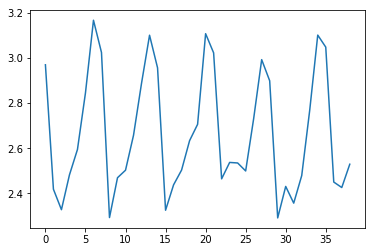

In [27]:
plt.plot(testpreds[129])

In [28]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [29]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.140631   
air_0164b9927d20bcc3_2017-04-23              1.282569   
air_0241aa3964b7f861_2017-04-23              2.238569   
air_0328696196e46f18_2017-04-23              2.174855   
air_034a3d5b40d5b1b1_2017-04-23              3.502690   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.504798  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.605891  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.379896  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.800909  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.204664

In [30]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [31]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [32]:
submission.to_csv("../submission/2002_lstm_run_1.csv.gz",compression='gzip')